# How to extract a file

In [ ]:
# !apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# !unzip -q "/content/data.zip"

unzip:  cannot find or open /content/data.zip, /content/data.zip.zip or /content/data.zip.ZIP.


In [ ]:
# delete folder
!rm -rf /content/sample_data

# Download github files & datasets

uncomment the following code to download the files
(remove the `#` for download data sets)

In [1]:
!apt install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
!git clone "https://github.com/rezapace/Machine-Learning-Sound-Detection"

Cloning into 'Machine-Learning-Sound-Detection'...
remote: Enumerating objects: 643, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 643 (delta 15), reused 30 (delta 8), pack-reused 606
Receiving objects: 100% (643/643), 277.34 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (611/611), done.


# Running the Sound Detection Program

In [3]:
!pip install pytube pydub
!pip install ffmpeg-python
!pip install pydub
!pip install pytube pydub ffmpeg-python
!apt-get install ffmpeg
!pip install pytube@git+https://github.com/priyankaj1311/pytube.git@master_copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Cloning https://github.com/priyankaj1311/pytube.git (to revision master_copy) to /tmp/pip-install-d49e_3f1/pytube_777d9f2f036f441d9104e3634685bc0c
  Running command git clone --filter=blob:none --quiet https://github.com/priyankaj1311/pytube.git /tmp/pip-install-d49e_3f1/pytube_777d9f2f036f441d9104e3634685bc0c
  Running command git checkout -b master_copy --track origin/master_copy
  Switched to a new branch 'master_copy'
  Branch 'master_copy' set up to track remote branch 'master_copy' from 'origin'.
  Resolved https://github.com/priyankaj1311/pytube.git to commit 68468bd1c0a2d3cd4166d928f4f7f44913c1f77f
  Preparing metadata (setup.py) ... done


In [4]:
import os
import io
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from IPython import display
from pytube import YouTube
from pydub import AudioSegment
from google.colab import files, output
from google.colab import files
from IPython.display import Javascript
from base64 import b64decode
from io import BytesIO
from IPython.display import Javascript, display
from google.colab import output
import ffmpeg

In [5]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['traffic' 'ambulance' 'firetruck']


In [6]:
# Load dataset
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.argmax(label == commands)  # Convert label to integer
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_dataset(data_dir):
    files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    output_ds = files.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [7]:
# Split dataset into training, validation, and test sets
full_ds = get_dataset(data_dir)
full_ds = full_ds.shuffle(buffer_size=10000, seed=seed, reshuffle_each_iteration=False)
full_ds_size = len(list(full_ds))

train_size = int(0.8 * full_ds_size)
val_size = int(0.1 * full_ds_size)
test_size = full_ds_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 480, Validation size: 60, Test size: 61


In [8]:
# Preprocess dataset
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [9]:
# Add a dimension to the input spectrogram
def add_batch_dimension(spectrogram, label):
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    return spectrogram, label

train_spectrogram_ds = train_spectrogram_ds.map(add_batch_dimension)
val_spectrogram_ds = val_spectrogram_ds.map(add_batch_dimension)
test_spectrogram_ds = test_spectrogram_ds.map(add_batch_dimension)

In [10]:
# Cache, shuffle, and prefetch the datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
# Build the model
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]

num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=(input_shape[0], input_shape[1], 1)),  # Add channel dimension
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
# Check the number of elements in the dataset
print(f"Number of elements in train dataset: {len(list(train_spectrogram_ds))}")
print(f"Number of elements in validation dataset: {len(list(val_spectrogram_ds))}")
print(f"Number of elements in test dataset: {len(list(test_spectrogram_ds))}")

Number of elements in train dataset: 15
Number of elements in validation dataset: 2
Number of elements in test dataset: 2


In [14]:
# Path to the dataset
DATASET_PATH = '/content/Machine-Learning-Sound-Detection/data'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['traffic' 'ambulance' 'firetruck']


In [15]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
15/15 [==============================] - 4s 176ms/step - loss: 0.8013 - accuracy: 0.6625 - val_loss: 0.4986 - val_accuracy: 0.8333
Epoch 2/10
15/15 [==============================] - 2s 105ms/step - loss: 0.4015 - accuracy: 0.8604 - val_loss: 0.2460 - val_accuracy: 0.8833
Epoch 3/10
15/15 [==============================] - 2s 108ms/step - loss: 0.3283 - accuracy: 0.8792 - val_loss: 0.2332 - val_accuracy: 0.9000
Epoch 4/10
15/15 [==============================] - 2s 102ms/step - loss: 0.2765 - accuracy: 0.8938 - val_loss: 0.1794 - val_accuracy: 0.9333
Epoch 5/10
15/15 [==============================] - 2s 104ms/step - loss: 0.1931 - accuracy: 0.9271 - val_loss: 0.1876 - val_accuracy: 0.9167
Epoch 6/10
15/15 [==============================] - 2s 104ms/step - loss: 0.1806 - accuracy: 0.9292 - val_loss: 0.1660 - val_accuracy: 0.9333
Epoch 7/10
15/15 [==============================] - 2s 146ms/step - loss: 0.1973 - accuracy: 0.9312 - val_loss: 0.1815 - val_accuracy: 0.9500
Epoch 

Text(0, 0.5, 'Accuracy [%]')

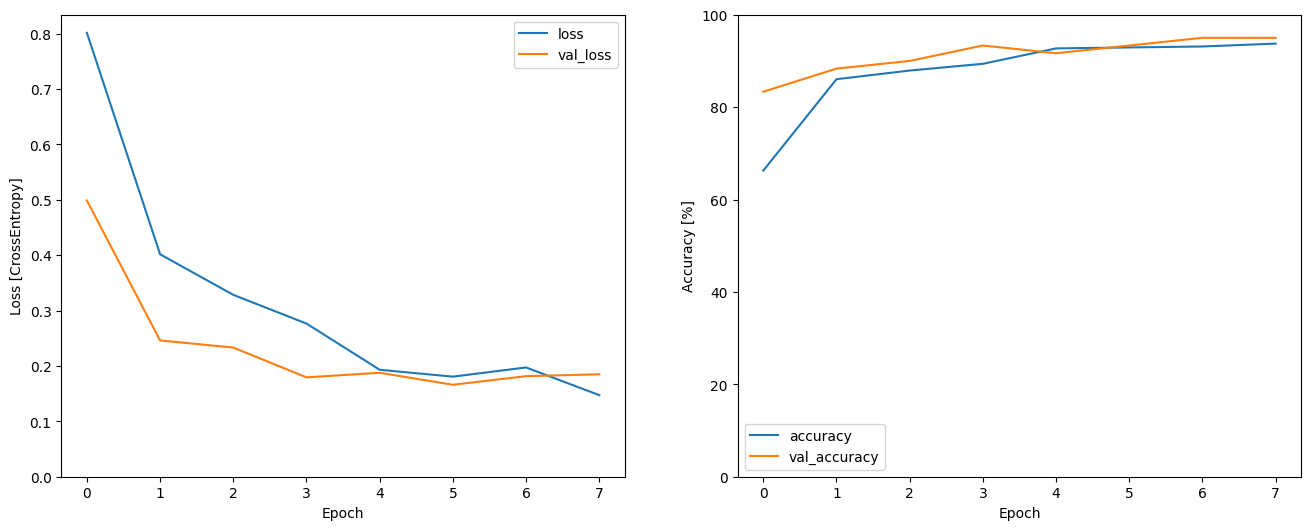

In [46]:
# Evaluate the model
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [47]:
# Evaluate on test set
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 0s 26ms/step - loss: 0.0757 - accuracy: 0.9836


{'loss': 0.07569784671068192, 'accuracy': 0.9836065769195557}

In [48]:
from sklearn.metrics import classification_report

# Prediksi pada data validasi atau test
y_true = []  # Label asli
y_pred = []  # Prediksi model

for spectrograms, labels in test_spectrogram_ds:
    predictions = model.predict(spectrograms)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=commands))

1/1 [==============================] - 0s 69ms/step
              precision    recall  f1-score   support

   firetruck       1.00      1.00      1.00        19
   ambulance       0.95      1.00      0.98        21
     traffic       1.00      0.95      0.98        21

    accuracy                           0.98        61
   macro avg       0.98      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



In [19]:
# Predict on new audio
def predict(model, file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimension
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Test from existing directory files

In [20]:
# Minta pengguna untuk memasukkan lokasi file audio
file_path = input("Enter the location of the audio file: ")

# Prediksi label dari file audio yang diberikan
predicted_label = predict(model, file_path)
print(f'Predicted label: {predicted_label}')

Masukkan lokasi file audio: /content/Machine-Learning-Sound-Detection/data/ambulance/sound_1.wav
Predicted label: ambulance


# Test With Youtube Link

In [21]:
# Function to download video from YouTube
def download_video_from_youtube(youtube_url, output_path='video.mp4'):
    yt = YouTube(youtube_url)
    video_stream = yt.streams.filter(only_audio=True).first()
    video_stream.download(filename=output_path)
    return output_path

# Function to convert MP4 to WAV
def convert_mp4_to_wav(mp4_path):
    try:
        audio = AudioSegment.from_file(mp4_path, format="mp4")
        wav_path = mp4_path.replace('.mp4', '.wav')
        audio.export(wav_path, format='wav')
        return wav_path
    except Exception as e:
        print(f"Error converting MP4 to WAV: {e}")
        return None

# Main function to download and convert YouTube video to WAV
def youtube_to_wav(youtube_url, output_dir='/content'):
    mp4_path = os.path.join(output_dir, 'video.mp4')
    wav_path = os.path.join(output_dir, 'audio.wav')

    # Download video from YouTube
    download_video_from_youtube(youtube_url, mp4_path)

    # Convert MP4 to WAV
    wav_path = convert_mp4_to_wav(mp4_path)

    if wav_path:
        print(f'Audio saved to: {wav_path}')
    else:
        print('Failed to convert audio to WAV.')

    return wav_path

# Function to decode audio
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

# Function to get spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

# Function to process and predict audio
def predict_audio(model, commands, filename):
    # Process audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Prompt user for YouTube URL
youtube_url = input('Please enter the YouTube video URL: ')

# Convert YouTube video to WAV
wav_path = youtube_to_wav(youtube_url)

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Predict the label of the converted audio file
predicted_label = predict_audio(model, commands, wav_path)
print(f'Predicted label: {predicted_label}')

Please enter the YouTube video URL: https://youtube.com/shorts/f1I7YYfoNrg?si=AvkAXV22202S2gWM
Audio saved to: /content/video.wav
Predicted label: ambulance


# Testing with file upload

In [22]:
# Function to upload files
def upload_audio():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
    return list(uploaded.keys())[0]

# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_path):
    audio = AudioSegment.from_mp3(mp3_path)
    wav_path = mp3_path.replace('.mp3', '.wav')
    audio.export(wav_path, format='wav')
    return wav_path

# Function to process and predict audio
def predict_uploaded_audio(model, commands, filename):
    # Convert MP3 to WAV if necessary
    if filename.endswith('.mp3'):
        filename = convert_mp3_to_wav(filename)

    # Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Upload audio files
filename = upload_audio()

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, filename)
print(f'Predicted label: {predicted_label}')

Saving sound_1.wav to sound_1.wav
User uploaded file "sound_1.wav" with length 529278 bytes
Predicted label: ambulance


# Testing live

In [23]:
# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# JavaScript untuk merekam audio
RECORD_JS = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = () => resolve(reader.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(resolve => {
  navigator.mediaDevices.getUserMedia({ audio: true }).then(stream => {
    const mediaRecorder = new MediaRecorder(stream)
    let chunks = []
    mediaRecorder.ondataavailable = e => chunks.push(e.data)
    mediaRecorder.start()
    sleep(time).then(() => {
      mediaRecorder.onstop = async () => {
        let blob = new Blob(chunks)
        let text = await b2text(blob)
        resolve(text)
      }
      mediaRecorder.stop()
    })
  })
})
"""

def fix_riff_header(binary):
    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, _ = process.communicate(input=binary)
    return output

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

def record(sec=3):
    display(Javascript(RECORD_JS))
    print("Recording...")
    s = output.eval_js('record(%d)' % (sec * 1000))
    b = b64decode(s.split(',')[1])
    b = fix_riff_header(b)
    with open('audio.wav', 'wb') as f:
        f.write(b)
    audio = AudioSegment.from_wav('audio.wav')
    return audio

def predict_uploaded_audio(model, commands, filename):
    #  Process uploaded audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Record audio for 15 seconds
audio = record(15)
audio.export("recorded_audio.wav", format="wav")

# Predict the label of the uploaded audio file
predicted_label = predict_uploaded_audio(model, commands, "recorded_audio.wav")
print(f'Predicted label: {predicted_label}')

# Play back the recorded audio
import IPython.display as ipd
ipd.Audio("recorded_audio.wav")

<IPython.core.display.Javascript object>

Recording...
Predicted label: ambulance


# Convert youtube to dataset

In [24]:
def download_video_from_youtube(youtube_url, output_path='video.mp4'):
    yt = YouTube(youtube_url)
    video_stream = yt.streams.filter(only_audio=True).first()
    video_stream.download(filename=output_path)
    return output_path

def convert_mp4_to_wav(mp4_path, wav_path='audio.wav'):
    audio = AudioSegment.from_file(mp4_path, format="mp4")
    audio.export(wav_path, format='wav')
    return wav_path

def split_audio_on_spikes(wav_path, output_dir, base_filename, max_segment_duration=5000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    audio = AudioSegment.from_wav(wav_path)
    samples = np.array(audio.get_array_of_samples())
    threshold = np.mean(np.abs(samples)) * 2  # Adjust threshold as needed

    spikes = np.where(np.abs(samples) > threshold)[0]
    spike_times = spikes / audio.frame_rate * 1000  # Convert to milliseconds

    segments = []
    start_time = 0
    for spike_time in spike_times:
        if spike_time - start_time > max_segment_duration:
            segments.append((start_time, spike_time))
            start_time = spike_time

    segments.append((start_time, len(audio)))

    existing_files = os.listdir(output_dir)
    existing_indices = [int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.startswith(base_filename)]
    next_index = max(existing_indices, default=0) + 1

    for i, (start, end) in enumerate(segments):
        segment = audio[start:end]
        segment_filename = f"{base_filename}_{next_index + i}.wav"
        segment.export(os.path.join(output_dir, segment_filename), format='wav')

    return segments

def main():
    youtube_url = input("Enter the YouTube URL: ")
    output_dir = input("Enter the storage location: ")
    base_filename = input("Enter the name of the base file (example: sound): ")

    mp4_path = download_video_from_youtube(youtube_url)
    wav_path = convert_mp4_to_wav(mp4_path)
    segments = split_audio_on_spikes(wav_path, output_dir, base_filename)
    print(f"Audio split into {len(segments)} segments.")

if __name__ == "__main__":
    main()

Masukkan URL YouTube: https://youtube.com/shorts/f1I7YYfoNrg?si=AvkAXV22202S2gWM
Masukkan lokasi penyimpanan: /content/sample_data
Masukkan nama file dasar (contoh: sound): s
Audio split into 2 segments.


# Filtering sounds that are missing and less than 5 seconds long

In [25]:
def is_silent(audio_segment, silence_threshold=-50.0, chunk_size=10):
    """
    Check if the audio segment is silent.
    :param audio_segment: AudioSegment object
    :param silence_threshold: Silence threshold in dB
    :param chunk_size: Size of chunks to analyze in ms
    :return: True if silent, False otherwise
    """
    chunks = audio_segment[::chunk_size]
    for chunk in chunks:
        if chunk.dBFS > silence_threshold:
            return False
    return True

def filter_silent_wav_files(folder_path, silence_threshold=-50.0, chunk_size=10):
    """
    Filter out silent WAV files in the given folder.
    :param folder_path: Path to the folder containing WAV files
    :param silence_threshold: Silence threshold in dB
    :param chunk_size: Size of chunks to analyze in ms
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            audio = AudioSegment.from_wav(file_path)
            if is_silent(audio, silence_threshold, chunk_size):
                os.remove(file_path)
                print(f"Removed silent file: {filename}")

if __name__ == "__main__":
    folder_path = input("Enter the location of the folder containing the WAV file: ")
    filter_silent_wav_files(folder_path)

Masukkan lokasi folder yang berisi file WAV: /content/sample_data
Removed silent file: s_2.wav


In [26]:
def is_silent(audio_segment, silence_threshold=-50.0, chunk_size=10):
    """
    Check if the audio segment is silent.
    :param audio_segment: AudioSegment object
    :param silence_threshold: Silence threshold in dB
    :param chunk_size: Size of chunks to analyze in ms
    :return: True if silent, False otherwise
    """
    chunks = audio_segment[::chunk_size]
    for chunk in chunks:
        if chunk.dBFS > silence_threshold:
            return False
    return True

def filter_wav_files(folder_path, silence_threshold=-50.0, chunk_size=10, min_duration=5000):
    """
    Filter out silent WAV files and files with duration less than min_duration in the given folder.
    :param folder_path: Path to the folder containing WAV files
    :param silence_threshold: Silence threshold in dB
    :param chunk_size: Size of chunks to analyze in ms
    :param min_duration: Minimum duration in milliseconds
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            audio = AudioSegment.from_wav(file_path)
            if is_silent(audio, silence_threshold, chunk_size) or len(audio) < min_duration:
                os.remove(file_path)
                print(f"Removed file: {filename}")

if __name__ == "__main__":
    folder_path = input("Enter the location of the folder containing the WAV file: ")
    filter_wav_files(folder_path)

Masukkan lokasi folder yang berisi file WAV: /content/sample_data
Removed file: s_1.wav


## Rename File Directory

In [27]:
def rename_files_in_directory(directory, base_name, start_index):
    # List all files in the directory
    files = os.listdir(directory)
    files.sort()  # Sort files to ensure consistent ordering

    # Filter out only files (ignore directories)
    files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

    # Rename files
    for i, filename in enumerate(files):
        file_extension = os.path.splitext(filename)[1]
        new_filename = f"{base_name}_{start_index + i}{file_extension}"
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
        print(f'Renamed: {filename} -> {new_filename}')

def main():
    directory = input("Enter the directory location: ")
    if os.path.isdir(directory):
        base_filename = input("Enter the base file name (example: sound_785): ")
        base_name, start_index = base_filename.rsplit('_', 1)
        start_index = int(start_index)
        rename_files_in_directory(directory, base_name, start_index)
    else:
        print("Invalid directory.")

if __name__ == "__main__":
    main()

Masukkan lokasi direktori: /content/Machine-Learning-Sound-Detection/data/ambulance
Masukkan nama file dasar (contoh: sound_785): sound_1
Renamed: sound_1.wav -> sound_1.wav
Renamed: sound_10.wav -> sound_2.wav
Renamed: sound_100.wav -> sound_3.wav
Renamed: sound_101.wav -> sound_4.wav
Renamed: sound_102.wav -> sound_5.wav
Renamed: sound_103.wav -> sound_6.wav
Renamed: sound_104.wav -> sound_7.wav
Renamed: sound_105.wav -> sound_8.wav
Renamed: sound_106.wav -> sound_9.wav
Renamed: sound_107.wav -> sound_10.wav
Renamed: sound_108.wav -> sound_11.wav
Renamed: sound_109.wav -> sound_12.wav
Renamed: sound_11.wav -> sound_13.wav
Renamed: sound_110.wav -> sound_14.wav
Renamed: sound_111.wav -> sound_15.wav
Renamed: sound_112.wav -> sound_16.wav
Renamed: sound_113.wav -> sound_17.wav
Renamed: sound_114.wav -> sound_18.wav
Renamed: sound_115.wav -> sound_19.wav
Renamed: sound_116.wav -> sound_20.wav
Renamed: sound_117.wav -> sound_21.wav
Renamed: sound_118.wav -> sound_22.wav
Renamed: sound_11

We hope this README provides a clear and engaging overview of the Machine Learning Detection Sound project. Join us in advancing the field of audio-based machine learning for automotive applications!

Regards,**Reza Hidayat** 👩🏻‍💻

# SELF TRAINING WITH 3 INPUT URL

In [43]:
import os
import numpy as np
import tensorflow as tf
from pydub import AudioSegment
from pytube import YouTube
from sklearn.model_selection import train_test_split

# Function to download video from YouTube
def download_video_from_youtube(youtube_url, output_path='video.mp4'):
    yt = YouTube(youtube_url)
    video_stream = yt.streams.filter(only_audio=True).first()
    video_stream.download(filename=output_path)
    return output_path

# Function to convert MP4 to WAV
def convert_mp4_to_wav(mp4_path, wav_path='audio.wav'):
    audio = AudioSegment.from_file(mp4_path, format="mp4")
    audio.export(wav_path, format='wav')
    return wav_path

# Function to split audio into 5-second segments
def split_audio(wav_path, output_dir, base_filename, start_index, segment_duration=5000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    audio = AudioSegment.from_wav(wav_path)
    segments = [audio[i:i + segment_duration] for i in range(0, len(audio), segment_duration)]

    for i, segment in enumerate(segments):
        segment_filename = f"{base_filename}_{start_index + i}.wav"
        segment.export(os.path.join(output_dir, segment_filename), format='wav')

    return len(segments)

# Function to check if audio is silent
def is_silent(audio_segment, silence_threshold=-50.0, chunk_size=10):
    chunks = audio_segment[::chunk_size]
    for chunk in chunks:
        if chunk.dBFS > silence_threshold:
            return False
    return True

# Function to filter out silent and short WAV files
def filter_wav_files(folder_path, silence_threshold=-50.0, chunk_size=10, min_duration=5000):
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            audio = AudioSegment.from_wav(file_path)
            if is_silent(audio, silence_threshold, chunk_size) or len(audio) < min_duration:
                os.remove(file_path)
                print(f"Removed file: {filename}")

# Function to create dataset
def create_dataset(data_dir, label_map):
    data = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    file_path = os.path.join(label_dir, filename)
                    data.append(file_path)
                    labels.append(label_map[label])
    return data, labels

# Function to preprocess dataset
def preprocess_dataset(data, labels):
    def decode_audio(audio_binary):
        audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
        return tf.squeeze(audio, axis=-1)

    def get_spectrogram(waveform):
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])
        return spectrogram

    def process_path(file_path, label):
        audio_binary = tf.io.read_file(file_path)
        waveform = decode_audio(audio_binary)
        spectrogram = get_spectrogram(waveform)
        return spectrogram, label

    file_paths = tf.convert_to_tensor(data)
    labels = tf.convert_to_tensor(labels)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Main function
def main():
    output_dir = 'data'
    categories = ['ambulance', 'firetruck', 'traffic']
    label_map = {category: i for i, category in enumerate(categories)}
    start_index = 1

    for category in categories:
        category_dir = os.path.join(output_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)

    for category in categories:
        youtube_url = input(f"Masukkan URL YouTube untuk {category}: ")
        mp4_path = download_video_from_youtube(youtube_url)
        wav_path = convert_mp4_to_wav(mp4_path)
        num_segments = split_audio(wav_path, os.path.join(output_dir, category), category, start_index)
        start_index += num_segments

    for category in categories:
        filter_wav_files(os.path.join(output_dir, category))

    data, labels = create_dataset(output_dir, label_map)
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

    train_ds = preprocess_dataset(train_data, train_labels).batch(32).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = preprocess_dataset(val_data, val_labels).batch(32).cache().prefetch(tf.data.AUTOTUNE)
    test_ds = preprocess_dataset(test_data, test_labels).batch(32).cache().prefetch(tf.data.AUTOTUNE)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(1032, 129, 1)),
        tf.keras.layers.Resizing(32, 32),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(categories)),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    model.fit(train_ds, validation_data=val_ds, epochs=70, callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)])
    model.evaluate(test_ds)

if __name__ == "__main__":
    main()

Masukkan URL YouTube untuk ambulance: https://youtu.be/fV9bO6AV30w?si=BCoCWeoiklwPNjCJ
Masukkan URL YouTube untuk firetruck: https://youtu.be/XtwoImMra1g?si=FWPQyvwAsSmBc2kc
Masukkan URL YouTube untuk traffic: https://youtu.be/SGZVfP7y4q8?si=Rp9MgVshXIW-CMUL
Removed file: ambulance_59.wav
Removed file: firetruck_180.wav
Removed file: firetruck_181.wav
Removed file: traffic_334.wav
Epoch 1/70
14/14 [==============================] - 11s 744ms/step - loss: 0.9800 - accuracy: 0.5550 - val_loss: 0.9188 - val_accuracy: 0.5794
Epoch 2/70
14/14 [==============================] - 1s 98ms/step - loss: 0.8482 - accuracy: 0.6511 - val_loss: 0.9350 - val_accuracy: 0.5327
Epoch 3/70
14/14 [==============================] - 1s 92ms/step - loss: 0.8221 - accuracy: 0.6276 - val_loss: 0.8395 - val_accuracy: 0.6262
Epoch 4/70
14/14 [==============================] - 1s 92ms/step - loss: 0.7116 - accuracy: 0.6979 - val_loss: 0.8316 - val_accuracy: 0.6542
Epoch 5/70
14/14 [==============================] 

In [44]:
import os

# Function to count dataset files
def count_dataset_files(data_dir):
    counts = {}
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            counts[label] = len([f for f in os.listdir(label_dir) if f.endswith('.wav')])
    return counts

def main():
    data_dir = 'data'  # Path to the directory containing the dataset
    counts = count_dataset_files(data_dir)
    for category, count in counts.items():
        print(f"Number of files in {category}: {count}")

if __name__ == "__main__":
    main()

Number of files in traffic: 167
Number of files in ambulance: 333
Number of files in firetruck: 168


In [45]:
# Function to download video from YouTube
def download_video_from_youtube(youtube_url, output_path='video.mp4'):
    yt = YouTube(youtube_url)
    video_stream = yt.streams.filter(only_audio=True).first()
    video_stream.download(filename=output_path)
    return output_path

# Function to convert MP4 to WAV
def convert_mp4_to_wav(mp4_path):
    try:
        audio = AudioSegment.from_file(mp4_path, format="mp4")
        wav_path = mp4_path.replace('.mp4', '.wav')
        audio.export(wav_path, format='wav')
        return wav_path
    except Exception as e:
        print(f"Error converting MP4 to WAV: {e}")
        return None

# Main function to download and convert YouTube video to WAV
def youtube_to_wav(youtube_url, output_dir='/content'):
    mp4_path = os.path.join(output_dir, 'video.mp4')
    wav_path = os.path.join(output_dir, 'audio.wav')

    # Download video from YouTube
    download_video_from_youtube(youtube_url, mp4_path)

    # Convert MP4 to WAV
    wav_path = convert_mp4_to_wav(mp4_path)

    if wav_path:
        print(f'Audio saved to: {wav_path}')
    else:
        print('Failed to convert audio to WAV.')

    return wav_path

# Function to decode audio
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    return tf.squeeze(audio, axis=-1)

# Function to get spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [1032, 129])  # Resize to expected shape
    return spectrogram

# Function to process and predict audio
def predict_audio(model, commands, filename):
    # Process audio
    audio_binary = tf.io.read_file(filename)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, -1)  # Add channel dimensions
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimensions

    # Prediction using the model
    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return commands[predicted_label.numpy()[0]]

# Prompt user for YouTube URL
youtube_url = input('Please enter the YouTube video URL: ')

# Convert YouTube video to WAV
wav_path = youtube_to_wav(youtube_url)

# Usage example
commands = np.array(['firetruck', 'ambulance', 'traffic'])  # Replace with appropriate label

# Predict the label of the converted audio file
predicted_label = predict_audio(model, commands, wav_path)
print(f'Predicted label: {predicted_label}')

Please enter the YouTube video URL: https://youtu.be/XtwoImMra1g?si=FWPQyvwAsSmBc2kc
Audio saved to: /content/video.wav
Predicted label: traffic


In [32]:
!rm -rf /content/sample_data